In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import collections
import itertools

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [5]:
from six.moves import urllib

In [6]:
print(np.__version__)
print(pd.__version__)
print(sp.__version__)
print(tf.__version__)

1.13.3
0.20.1
1.0.0
1.4.1


In [7]:
mnist = input_data.read_data_sets("mnist_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [76]:
def display_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap="Greys", interpolation='nearest')

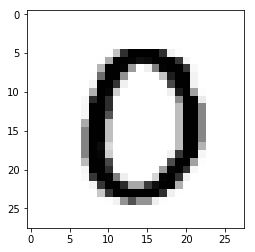

In [77]:
display_digit(mnist.train.images[10])

In [139]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_feature_maps = conv2_feature_maps

n_fullyconn1 = 64
n_outputs = 10

In [140]:
def build_cnn(features):

    X = tf.reshape(features['images'], shape=[-1, height, width, channels])

    conv1 = tf.layers.conv2d(X, filters=conv1_feature_maps,
                             kernel_size=conv1_kernel_size,
                             strides=conv1_stride, padding=conv1_pad,
                             activation=tf.nn.relu)
    
    conv2 = tf.layers.conv2d(conv1, filters=conv2_feature_maps, 
                             kernel_size=conv2_kernel_size,
                             strides=conv2_stride, padding=conv2_pad,
                             activation=tf.nn.relu)
    
    pool3 = tf.nn.max_pool(conv2,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding="VALID")
    
    
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps * 7 * 7])
    
    fullyconn1 = tf.layers.dense(pool3_flat, n_fullyconn1,
                                 activation=tf.nn.relu)
    
    logits = tf.layers.dense(fullyconn1, n_outputs)
    
    return logits    

In [141]:
def cnn_model_fn(features, labels, mode):
    
    logits = build_cnn(features)
    
    predicted_classes = tf.argmax(logits, axis=1)
    
    # Prediction mode    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=predicted_classes)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    # Training mode    
    if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    
    # Evaluation mode    
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes)
    
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predicted_classes,
        train_op=train_op,
        loss=loss,
        eval_metric_ops={'accuracy': accuracy})

In [142]:
num_steps = 2000
batch_size = 100

In [143]:
model = tf.estimator.Estimator(cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x114753810>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/yd/1rlyjfk975d3bb98d7_nyt740000gn/T/tmpOkepMC', '_save_summary_steps': 100}


In [144]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

In [145]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/yd/1rlyjfk975d3bb98d7_nyt740000gn/T/tmpOkepMC/model.ckpt.
INFO:tensorflow:loss = 2.30638, step = 1
INFO:tensorflow:global_step/sec: 7.59427
INFO:tensorflow:loss = 0.112845, step = 101 (13.171 sec)
INFO:tensorflow:global_step/sec: 7.52085
INFO:tensorflow:loss = 0.10263, step = 201 (13.295 sec)
INFO:tensorflow:global_step/sec: 8.26299
INFO:tensorflow:loss = 0.084625, step = 301 (12.102 sec)
INFO:tensorflow:global_step/sec: 8.43335
INFO:tensorflow:loss = 0.0516369, step = 401 (11.858 sec)
INFO:tensorflow:global_step/sec: 8.48616
INFO:tensorflow:loss = 0.024489, step = 501 (11.784 sec)
INFO:tensorflow:global_step/sec: 8.47863
INFO:tensorflow:loss = 0.0782672, step = 601 (11.794 sec)
INFO:tensorflow:global_step/sec: 8.50595
INFO:tensorflow:loss = 0.032685, step = 701 (11.757 sec)
INFO:tensorflow:global_step/sec: 8.43757
INFO:tensorflow:loss = 0.154804, step = 801 (11.852 sec)
INFO:tensorfl

In [146]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)


In [147]:
e = model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2017-12-21-08:15:04
INFO:tensorflow:Restoring parameters from /var/folders/yd/1rlyjfk975d3bb98d7_nyt740000gn/T/tmpOkepMC/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-12-21-08:15:08
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9832, global_step = 2000, loss = 0.0667596


In [148]:
print("Testing Accuracy:", e['accuracy'])

Testing Accuracy: 0.9832
